In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [15]:
original_dataset_dir = "/Users/maithilimahadik/Desktop/The IQ-OTHNCCD lung cancer dataset"  
output_base_dir = "/Users/maithilimahadik/Data-2"  

In [17]:
classes = ['Normal', 'Malignant', 'Benign']

In [19]:
train_path = os.path.join(output_base_dir, "train")
val_path = os.path.join(output_base_dir, "valid")
test_path = os.path.join(output_base_dir, "test")

In [21]:
datagen = ImageDataGenerator(rescale=1./255)

In [23]:
train_gen = datagen.flow_from_directory(train_path, classes=classes, target_size=(224, 224), batch_size=32, class_mode="sparse")
val_gen = datagen.flow_from_directory(val_path, classes=classes, target_size=(224, 224), batch_size=32, class_mode="sparse")
test_gen = datagen.flow_from_directory(test_path, classes=classes, target_size=(224, 224), batch_size=32, class_mode="sparse", shuffle=False)


Found 1010 images belonging to 3 classes.
Found 308 images belonging to 3 classes.
Found 309 images belonging to 3 classes.


In [25]:
model_file = "lung_model.h5"
if os.path.exists(model_file):
    model = tf.keras.models.load_model(model_file)
else:
    base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers:
        layer.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(len(classes), activation='softmax')(x)
    model = Model(inputs=base.input, outputs=out)

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    hist = model.fit(train_gen, validation_data=val_gen, epochs=10)
    model.save(model_file)

    plt.plot(hist.history["loss"], label="Train Loss")
    plt.plot(hist.history["val_loss"], label="Val Loss")
    plt.legend()
    plt.show()

📂 Loading existing model...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6472 - loss: 0.7576
Test Loss: 0.7576, Test Accuracy: 64.72%
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step


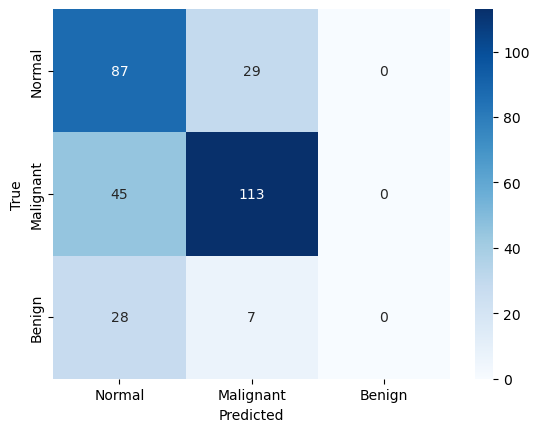


Classification Report:

              precision    recall  f1-score   support

      Normal       0.54      0.75      0.63       116
   Malignant       0.76      0.72      0.74       158
      Benign       0.00      0.00      0.00        35

    accuracy                           0.65       309
   macro avg       0.43      0.49      0.46       309
weighted avg       0.59      0.65      0.61       309



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
loss, acc = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc*100:.2f}%")

y_true = test_gen.classes
y_prob = model.predict(test_gen)
y_pred = np.argmax(y_prob, axis=1)

labels_present = np.unique(y_true)
cm = confusion_matrix(y_true, y_pred, labels=labels_present)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[classes[i] for i in labels_present],
            yticklabels=[classes[i] for i in labels_present])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, labels=labels_present, target_names=[classes[i] for i in labels_present]))


In [31]:
from PIL import Image

img_path = "/Users/maithilimahadik/Desktop/The IQ-OTHNCCD lung cancer dataset/Malignant/Malignant case (2).jpg"  
img = Image.open(img_path).resize((224, 224))
arr = np.array(img) / 255.0
arr = np.expand_dims(arr, axis=0)

pred = model.predict(arr)
label = classes[np.argmax(pred)]
confidence = np.max(pred) * 100
print(f"Prediction: {label}, Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
Prediction: Malignant, Confidence: 86.64%
